In [5]:
import pandas as pd
import numpy as np
import torch
import importlib
from utils.utils_dataset import prepare_k_fold_non_iid_dataset, plot_dataset_split, display_dataset_split
from sklearn import datasets
from sklearn.model_selection import KFold
from utils.utils_train import train_unsupervised, train_supervised, test_model
from utils.utils_plots import plot_first_feature_horizontal, save_figure
from utils.utils_metrics import calculate_metrics_statistics, calculate_cluster_stats, calculate_metrics, plot_confusion_matrix, calculate_unsupervised_metrics
from utils.utils_metrics import compute_bic

In [6]:
from model.eGauss_plus import eGAUSSp

print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)

# Check if CUDA is available
#if torch.cuda.is_available():
    #device = torch.device("cuda")
    #print("CUDA is available. Using GPU.")
#else:
device = torch.device("cpu")
print("CUDA not available. Using CPU.")

# Model parameters
local_model_params = {
    "feature_dim": 2,
    "num_classes": 3,
    "kappa_n": 4,
    "num_sigma": 2,
    "kappa_join": 0.5,
    "S_0": 1e-8,
    "c_max": 10,
    "device": device
}
federated_model_params = {
    "feature_dim": 2,
    "num_classes": 3,
    "kappa_n": 1,
    "num_sigma": 2,
    "kappa_join": 1.1,
    "S_0": 1e-8,
    "c_max": 2,
    "device": device
}

PyTorch Version: 2.1.1
CUDA Version: None
CUDA not available. Using CPU.


In [7]:
# Generate the data as provided
z_1 = np.random.randn(2, 250)
z_2_top = np.random.randn(1, 100)
z_2 = np.vstack((z_2_top, -z_2_top + (8 + 0.85 * np.random.randn(1, 100))))
z_3_top = -1.5 + 0.5 * np.random.randn(1, 50)
z_3 = np.vstack((z_3_top, -z_3_top + (4 + 0.5 * np.random.randn(1, 50))))

labels_1 = 0*np.ones((z_1.shape[1],), dtype=np.int32)  # Label 0 for z_1 cluster
labels_2 = 1*np.ones((z_2.shape[1],), dtype=np.int32)  # Label 1 fsssssssssor z_2 cluster
labels_3 = 2*np.ones((z_3.shape[1],), dtype=np.int32)  # Label 2 for z_3 cluster

# Concatenate the data and labels
z = np.hstack((z_1, z_2, z_3))
labels = np.hstack((labels_1, labels_2, labels_3))

# Shuffle the data and labels in the same order
indices = np.random.permutation(z.shape[1])
data = z[:, indices].transpose()
labels = labels[indices]


*** Start of fold 0. ***
Debugging has been enabled.

Training model for client 1
Evolving has been enabled.
Number of clusters with multiple samples for Client 1 = 11
Debugging has been enabled.

Training model for client 2
Evolving has been enabled.
Number of clusters with multiple samples for Client 2 = 16
Debugging has been enabled.

Training model for client 3
Evolving has been enabled.
Number of clusters with multiple samples for Client 3 = 18
Debugging has been enabled.

Training model for client 4
Evolving has been enabled.
Number of clusters with multiple samples for Client 4 = 16

Number of clusters after transfer = 61
Number of clusters after merging = 3
Evolving has been disabled.

*** Start of fold 1. ***
Debugging has been enabled.

Training model for client 1
Evolving has been enabled.
Number of clusters with multiple samples for Client 1 = 9
Debugging has been enabled.

Training model for client 2
Evolving has been enabled.
Label of cluster index is in labels of matchi

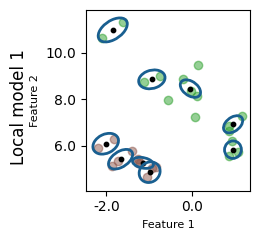

Figure saved as Images/synthetic_model_1.svg in svg format.
Figure saved as Images/synthetic_local_model_1.pdf in pdf format.


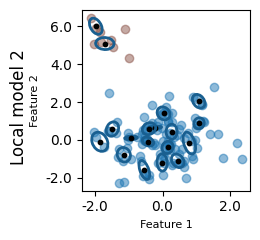

Figure saved as Images/synthetic_model_2.svg in svg format.
Figure saved as Images/synthetic_local_model_2.pdf in pdf format.


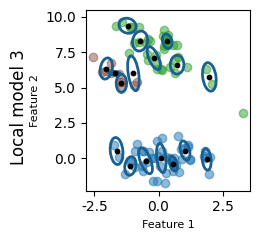

Figure saved as Images/synthetic_model_3.svg in svg format.
Figure saved as Images/synthetic_local_model_3.pdf in pdf format.


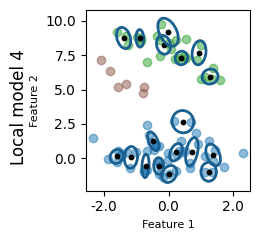

Figure saved as Images/synthetic_model_4.svg in svg format.
Figure saved as Images/synthetic_local_model_4.pdf in pdf format.


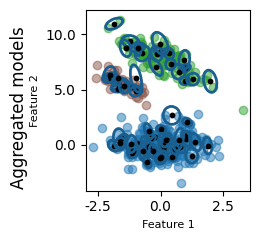

Figure saved as Images/synthetic_federated_pre_merge.svg in svg format.
Figure saved as Images/synthetic_federated_pre_merge.pdf in pdf format.

Number of clusters after transfer = 62
Number of clusters after merging = 3
Evolving has been disabled.


In [8]:


X = data
y = labels

num_clients = 4
num_splits = 5

kf = KFold(n_splits=num_splits, shuffle=True, random_state=None)  

# Initialize arrays to track samples per class for each client in each fold
samples_per_class_per_client = np.zeros((num_clients, local_model_params["num_classes"], num_splits))

# Main loop for k-fold cross-validation
#all_client_metrics = [[] for _ in range(num_clients)]
all_client_clusters = [[] for _ in range(num_clients)]
all_agregated_clusters = []
all_federated_metrics = []
all_federated_clusters = []
all_federated_bic = []

for i_fold, (train_index, test_index) in enumerate(kf.split(data)):
    print(f"\n*** Start of fold {i_fold}. ***")
    
    #Split the data
    train_data, test_data, all_data = prepare_k_fold_non_iid_dataset(X, y, train_index, test_index, num_clients)
    
    #Create the models
    local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]
    federated_model = eGAUSSp(**federated_model_params)
    #federated_model.toggle_debugging(True)
    
    #Train the models
    for client_idx, client_model in enumerate(local_models):
        client_model.toggle_debugging(True)

        # Count the number of samples per class for this client in this fold
        for class_idx in range(client_model.num_classes):
            class_samples = torch.sum(train_data[client_idx][1] == class_idx)
            samples_per_class_per_client[client_idx, class_idx, i_fold] = class_samples

        #unsupervised clustering
        print(f"\nTraining model for client {client_idx + 1}")
        train_unsupervised(client_model, train_data[client_idx]) 

        #Test the local models

        #Save the number of clusters
        num_client_clusters = torch.sum(client_model.n[:client_model.c] > 1).item()
        print(f"Number of clusters with multiple samples for Client {client_idx + 1} = {num_client_clusters}")
        all_client_clusters[client_idx].append(num_client_clusters)

    #Aggregate local models
    for client_idx, client_model in enumerate(local_models):
        federated_model.federal_agent.merge_model_privately(client_model, 1)
        num_agregated_clusters = torch.sum(federated_model.n[:federated_model.c] > 1).item()
        all_agregated_clusters.append(num_agregated_clusters)

        #Plot local models
        if i_fold == (num_splits-1):
                
            #Plot the local models
            fig = plot_first_feature_horizontal(train_data[client_idx], model=client_model, num_sigma=2, N_max=1, title=f"Local model {client_idx+1}")  
            save_figure(fig, f"Images/synthetic_model_{client_idx+1}.svg", "svg")
            save_figure(fig, f"Images/synthetic_local_model_{client_idx+1}.pdf","pdf")


    #Plot the Aggregated model
    if i_fold == (num_splits-1):
        fig = plot_first_feature_horizontal(all_data, model=federated_model, num_sigma=2, N_max=0, title="Aggregated models")   
        save_figure(fig, "Images/synthetic_federated_pre_merge.svg","svg")
        save_figure(fig, "Images/synthetic_federated_pre_merge.pdf","pdf")

    #Merge the federated model clusters
    print(f"\nNumber of clusters after transfer = {federated_model.c}")
    federated_model.federal_agent.federated_merging()
    num_federated_clusters = torch.sum(federated_model.n[:federated_model.c] > 1).item()
    print(f"Number of clusters after merging = {federated_model.c}")
    all_federated_clusters.append(num_federated_clusters)
    
    #Test the federated model
    #calculate_unsupervised_metrics()
    _,_, cluster_assignment = test_model(federated_model, test_data)

    federated_metrics = calculate_unsupervised_metrics(cluster_assignment, test_data)
    #num_params = federated_model.c*(federated_model.feature_dim**2 + federated_model.feature_dim +1)
    #bic = compute_bic(cluster_assignment.detach().numpy(), num_params)
    all_federated_metrics.append(federated_metrics)
    #all_federated_bic.append(bic)

Client 1: {1: 16, 2: 11}
Client 2: {0: 109, 2: 9}
Client 3: {0: 47, 1: 37, 2: 11}
Client 4: {0: 48, 1: 26, 2: 6}
Test Set: {0: 46, 1: 21, 2: 13}

Combined Number of Samples per Class:
Class 0: 250 samples
Class 1: 100 samples
Class 2: 50 samples

Total Number of Samples Across All Datasets: 400
Figure saved as Images/synthetic_data_distribution.svg in svg format.
Figure saved as Images/synthetic_data_distribution.pdf in pdf format.


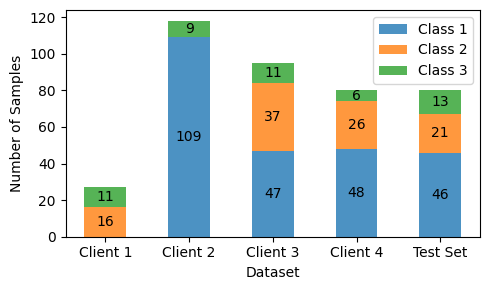

In [9]:
#Aditional plots of the data
display_dataset_split(train_data, test_data)
fig = plot_dataset_split(train_data, test_data)
save_figure(fig, "Images/synthetic_data_distribution.svg","svg")
save_figure(fig, "Images/synthetic_data_distribution.pdf","pdf")

In [10]:

#Calculate evaluation metrics for the federated model
avg_std_federated_metrics = calculate_metrics_statistics(all_federated_metrics)

#Calculate evaluation metrics for the federated model
avg_std_federated_bic = np.mean([metrics for metrics in all_federated_bic])
print(f"BIC: {avg_std_federated_bic}")
                          
print("\nFederated Model - Metrics (mean ± std):")
for metric, value in avg_std_federated_metrics.items():
    print(f"{metric}: {value}")


# Compute and print cluster stats for each client and federated model
for client_idx, client_clusters in enumerate(all_client_clusters):
    avg_clusters, std_clusters = calculate_cluster_stats(client_clusters)
    print(f"Client {client_idx + 1} - Average Number of Clusters (mean ± std): {avg_clusters:.2f} ± {std_clusters:.2f}")

# Compute and print cluster stats for the agregared models before merging into the  federated model
avg_agr_clusters, std_agr_clusters = calculate_cluster_stats(all_agregated_clusters)
print(f"Agregated Model - Average Number of Clusters (mean ± std): {avg_agr_clusters:.2f} ± {std_agr_clusters:.2f}")

# Compute and print cluster stats for the federated model
avg_fed_clusters, std_fed_clusters = calculate_cluster_stats(all_federated_clusters)
print(f"Federated Model - Average Number of Clusters (mean ± std): {avg_fed_clusters:.2f} ± {std_fed_clusters:.2f}")


BIC: nan

Federated Model - Metrics (mean ± std):
silhouette_score: 0.61 ± 0.05
normalized_mutual_info_score: 1.00 ± 0.00
v_measure_score: 1.00 ± 0.00
Client 1 - Average Number of Clusters (mean ± std): 9.40 ± 1.14
Client 2 - Average Number of Clusters (mean ± std): 17.20 ± 1.10
Client 3 - Average Number of Clusters (mean ± std): 17.60 ± 0.89
Client 4 - Average Number of Clusters (mean ± std): 15.80 ± 2.28
Agregated Model - Average Number of Clusters (mean ± std): 35.05 ± 19.51
Federated Model - Average Number of Clusters (mean ± std): 3.00 ± 0.00


c:\Users\Miha\anaconda3\envs\eGaussP\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Miha\anaconda3\envs\eGaussP\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


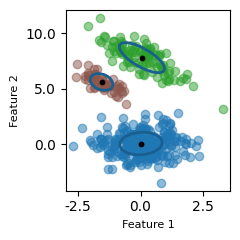

Number of clusters after merging = 3
Figure saved as Images/synthetic__federated_merged.svg in svg format.
Figure saved as Images/synthetic__federated_merged.pdf in pdf format.


In [11]:
#Plot of the last federated model
fig = plot_first_feature_horizontal(all_data, model=federated_model, num_sigma=2, N_max=0, title="", legend=False)   
print(f"Number of clusters after merging = {federated_model.c}")
save_figure(fig, "Images/synthetic__federated_merged.svg","svg")
save_figure(fig, "Images/synthetic__federated_merged.pdf","pdf")
